#### Creating Labels

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
labels_csv = {'train': "/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/Notebooks/weekly_supervised/new_image_labels_train.csv",
             'test': "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/image_labels_test.csv"
             }

In [4]:
train_csv = pd.read_csv(labels_csv['train'])
test_csv = pd.read_csv(labels_csv['test'])

In [5]:
new_train = pd.DataFrame(columns=['image_id', 'Abnormal'])
new_train['image_id'] = train_csv['image_id']
new_train['Abnormal'] = 0

In [6]:
for i in train_csv.index:
    if train_csv.loc[i]['No finding'] == 0:
        new_train.loc[i,'Abnormal'] = 1
new_train.to_csv("./train_normal_vs_abnormal.csv", index= False)

In [7]:
new_test = pd.DataFrame(columns=['image_id', 'Abnormal'])
new_test['image_id'] = test_csv['image_id']
new_test['Abnormal'] = 0
for i in test_csv.index:
    if test_csv.loc[i]['No finding'] == 0:
        new_test.loc[i,'Abnormal'] = 1
new_test.to_csv("./test_normal_vs_abnormal.csv", index= False)

### Experiment

In [8]:
import numpy as np
import torch
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
torch.manual_seed(0)
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import transforms, models, datasets

from PIL import Image

from torch import nn
from torch import optim
from tqdm.notebook import tqdm

In [12]:
train_csv = pd.read_csv("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/Notebooks/normal_vs_abnormal/train_normal_vs_abnormal.csv")
test_csv = pd.read_csv("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/Notebooks/normal_vs_abnormal/test_normal_vs_abnormal.csv")

<AxesSubplot:xlabel='Abnormal'>

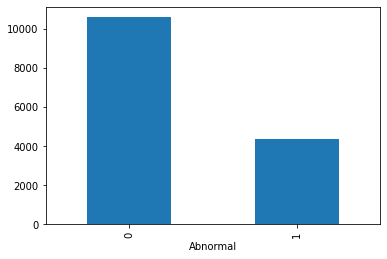

In [13]:
train_csv.groupby(['Abnormal']).count().plot(kind = 'bar', legend = False)

<AxesSubplot:xlabel='Abnormal'>

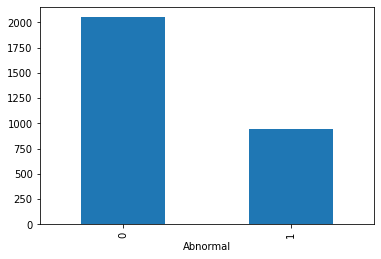

In [14]:
test_csv.groupby(['Abnormal']).count().plot(kind = 'bar', legend = False)

In [15]:
class normal_vs_abnormal_dataset(Dataset):
    def __init__(self, label_loc, img_location, transform,  data_type= 'train'):
        label_dataframe = pd.read_csv(label_loc)
        label_dataframe.set_index("image_id", inplace = True)
        filenames = label_dataframe.index.values
        self.full_filename = [os.path.join(img_location,i+'.png') for i in filenames]
        self.labels = label_dataframe.iloc[:,0].values
        self.transform = transform
    def __len__(self):
        return len(self.full_filename)
    
    def __getitem__(self, idx):
        
        image = Image.open(self.full_filename[idx])
        image = self.transform(image)
        return image, np.expand_dims(np.array(self.labels[idx]), axis = 0)

In [43]:
data_transforms = { 
    "train": transforms.Compose([
        transforms.Grayscale(),
        transforms.CenterCrop((224,224)),
        transforms.RandomHorizontalFlip(p = 0.5), 
        transforms.RandomPerspective(distortion_scale=0.3),
        transforms.RandomRotation((-30,30)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485], std = [0.229])
    ]),
    
    "test": transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485], std = [0.229])        
    ])
    
}

In [45]:
train_data = normal_vs_abnormal_dataset("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/Notebooks/normal_vs_abnormal/train_normal_vs_abnormal.csv",
                                       img_location = "/scratch/scratch6/akansh12/DeepEXrays/data/data_256/train/", transform =data_transforms['train'])

test_data = normal_vs_abnormal_dataset("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/Notebooks/normal_vs_abnormal/test_normal_vs_abnormal.csv",
                                       img_location = "/scratch/scratch6/akansh12/DeepEXrays/data/data_256/test/", transform =data_transforms['test'])

trainloader = DataLoader(train_data,batch_size = 1,shuffle = True)
testloader = DataLoader(test_data,batch_size = 8,shuffle = False)

In [46]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes= np.unique(train_data.labels), y= train_data.labels) 
print(class_weights)



[0.7071469  1.70687301]


In [47]:
import torchxrayvision as xrv
model = xrv.models.DenseNet(weights="densenet121-res224-chex")
from collections import OrderedDict
from torch import nn
model.classifier = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(1024,1)),
    ('out', nn.Sigmoid()),
]))

In [48]:

def train_one_epoch(model, optimizer, lr_scheduler,
                    dataloader, epoch, criterion, device):
    
    print("Start Train ...")
    model.train()

    losses_train = []
    model_train_result = []
    train_target = []


    for data, targets in tqdm(dataloader):
        data = data.to(device)
        targets = targets.to(device).type(torch.float)


        outputs = model(data)
        model_train_result.extend(outputs.detach().cpu().numpy().tolist())
        train_target.extend(targets.cpu().numpy())


        loss = criterion(outputs, targets)

        losses_train.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    F1_train = f1_score(train_target, (np.array(model_train_result) > 0.5), average=None)

        
    if lr_scheduler is not None:
        lr_scheduler.step()

    lr = lr_scheduler.get_last_lr()[0]
    print("Epoch [%d]" % (epoch),
          "Mean loss on train:", np.array(losses_train).mean(), 
          "F1 score:",np.array(F1_train),
          "Learning Rate:", lr)

    
    return np.array(losses_train).mean(), np.array(F1_train), lr


def val_epoch(model, dataloader, epoch, criterion, device):
    
    print("Start Validation ...")
    model.eval()
    
    model_val_result = []
    val_target = []
    losses_val = []

    with torch.no_grad():
        for data, targets in tqdm(dataloader):

            data = data.to(device)
            targets = targets.to(device).type(torch.float)

            outputs = model(data)
            
            #loss
            loss = criterion(outputs, targets)
            losses_val.append(loss.item())

            
            model_val_result.extend(outputs.detach().cpu().numpy().tolist())
            val_target.extend(targets.cpu().numpy())
            
        F1_val = f1_score(val_target, (np.array(model_val_result) > 0.5), average=None)




        print("Epoch:  " + str(epoch) + " F1 valid Score:", np.array(F1_val), 
              "Mean Loss", np.array(losses_val).mean())
        
    return np.array(losses_val).mean(), np.array(F1_val)



In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    model = model.cuda()
    model = nn.DataParallel(model)

In [50]:
for param in model.parameters():
    param.requires_grad = True
num_epochs = 50
optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.1, steps_per_epoch=1, epochs=50)
# criterion = nn.BCELoss(reduction= 'mean')
criterion = nn.BCEWithLogitsLoss(pos_weight= torch.tensor([0.7071469,  1.70687301]))

In [51]:
train_loss_history = []
val_loss_history = []
train_f1_history = []
val_f1_history = []
lr_history = []
weights_dir = "/scratch/scratch6/akansh12/DeepEXrays/global_label/efficient-net/"


for epoch in range(num_epochs):
    
    
    train_loss, train_f1, lr = train_one_epoch(model, optimizer, lr_scheduler,trainloader, epoch, criterion, device = device)
    val_loss, val_f1 = val_epoch(model, testloader, epoch, criterion, device = device)
    
    
    # train history
    train_loss_history.append(train_loss)
    train_f1_history.append(train_f1)
    lr_history.append(lr)
    
    #val history
    val_loss_history.append(val_loss)
    val_f1_history.append(val_f1)
    
    # save best weights
    best_loss = min(val_loss_history)
    if (val_loss <= best_loss) or (epoch % 10 == 0):
        print('saving model')
        torch.save({'state_dict': model.state_dict()},
                    os.path.join(weights_dir, f"A_N_{val_loss:0.6f}_{epoch}_.pth"))


Start Train ...


  0%|          | 0/15000 [00:00<?, ?it/s]

IndexError: The shape of the mask [1, 18] at index 1 does not match the shape of the indexed tensor [1, 1] at index 1

In [ ]:
np.save("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/model/eff_train_loss_hist_A_N_label.npy", np.array(train_loss_history))
np.save("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/model/eff_test_loss_hist_A_N_label.npy", np.array(val_loss_history))
np.save("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/model/eff_train_f1_hist_A_N_label.npy", np.array(train_f1_history))
np.save("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/model/eff_test_f1_hist_A_N_label.npy", np.array(val_f1_history))

In [55]:
model.state_dict()

OrderedDict([('op_threshs',
              tensor([0.1989, 0.0571,    nan, 0.0531, 0.1435,    nan,    nan, 0.2721, 0.0775,
                         nan, 0.1971,    nan,    nan,    nan, 0.0993, 0.0927, 0.3271, 0.1089])),
             ('features.conv0.weight',
              tensor([[[[-0.2164, -0.1203,  0.1123,  ..., -0.1488, -0.3931, -0.4193],
                        [-0.5876, -0.2672, -0.0941,  ..., -0.2405,  0.0073, -0.0152],
                        [-0.1729, -0.0393, -0.0893,  ...,  0.1591,  0.0360, -0.0049],
                        ...,
                        [ 0.1176, -0.0069,  0.3819,  ...,  0.1150,  0.1133,  0.0853],
                        [ 0.1336,  0.4236,  0.2588,  ...,  0.0491, -0.1341,  0.0955],
                        [ 0.1736,  0.2371,  0.3519,  ...,  0.2000, -0.0303,  0.0888]]],
              
              
                      [[[-0.1490,  0.2463,  0.0790,  ...,  0.1193, -0.0852, -0.0029],
                        [-0.0048,  0.0055, -0.0398,  ..., -0.3835, -0.2593, -0.

In [58]:
models.DenseNet().load_state_dict(model.state_dict())

RuntimeError: Error(s) in loading state_dict for DenseNet:
	Missing key(s) in state_dict: "classifier.weight", "classifier.bias". 
	Unexpected key(s) in state_dict: "op_threshs", "classifier.fcl1.weight", "classifier.fcl1.bias". 
	size mismatch for features.conv0.weight: copying a param with shape torch.Size([64, 1, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 3, 7, 7]).

In [69]:
model.state_dict()

OrderedDict([('op_threshs',
              tensor([0.1989, 0.0571,    nan, 0.0531, 0.1435,    nan,    nan, 0.2721, 0.0775,
                         nan, 0.1971,    nan,    nan,    nan, 0.0993, 0.0927, 0.3271, 0.1089])),
             ('features.conv0.weight',
              tensor([[[[-0.2164, -0.1203,  0.1123,  ..., -0.1488, -0.3931, -0.4193],
                        [-0.5876, -0.2672, -0.0941,  ..., -0.2405,  0.0073, -0.0152],
                        [-0.1729, -0.0393, -0.0893,  ...,  0.1591,  0.0360, -0.0049],
                        ...,
                        [ 0.1176, -0.0069,  0.3819,  ...,  0.1150,  0.1133,  0.0853],
                        [ 0.1336,  0.4236,  0.2588,  ...,  0.0491, -0.1341,  0.0955],
                        [ 0.1736,  0.2371,  0.3519,  ...,  0.2000, -0.0303,  0.0888]]],
              
              
                      [[[-0.1490,  0.2463,  0.0790,  ...,  0.1193, -0.0852, -0.0029],
                        [-0.0048,  0.0055, -0.0398,  ..., -0.3835, -0.2593, -0.

In [65]:
len(models.DenseNet().state_dict().keys())

727

In [67]:
models.densenet121().state_dict().keys()

odict_keys(['features.conv0.weight', 'features.norm0.weight', 'features.norm0.bias', 'features.norm0.running_mean', 'features.norm0.running_var', 'features.norm0.num_batches_tracked', 'features.denseblock1.denselayer1.norm1.weight', 'features.denseblock1.denselayer1.norm1.bias', 'features.denseblock1.denselayer1.norm1.running_mean', 'features.denseblock1.denselayer1.norm1.running_var', 'features.denseblock1.denselayer1.norm1.num_batches_tracked', 'features.denseblock1.denselayer1.conv1.weight', 'features.denseblock1.denselayer1.norm2.weight', 'features.denseblock1.denselayer1.norm2.bias', 'features.denseblock1.denselayer1.norm2.running_mean', 'features.denseblock1.denselayer1.norm2.running_var', 'features.denseblock1.denselayer1.norm2.num_batches_tracked', 'features.denseblock1.denselayer1.conv2.weight', 'features.denseblock1.denselayer2.norm1.weight', 'features.denseblock1.denselayer2.norm1.bias', 'features.denseblock1.denselayer2.norm1.running_mean', 'features.denseblock1.denselayer2